# Assignment 1: Bandits and Exploration/Exploitation

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import main_agent   
import ten_arm_env  #It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit-variance.
import test_env
from tqdm import tqdm_notebook as tqdm
import time


In [82]:
!pip install agents

# Section 1: Greedy Agent

- create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value.

- argmax function, which takes in a list of action values and returns an action with the highest value.

- Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases


In [83]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    ties=[]
    top = float("-inf")
    for i in range(0,len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i]==top:
            ties.append(i)
    return np.random.choice(ties)

In [84]:
# testing argmax function
test_array = [1,0,0,0,0,0,0,0,1,0]
print(argmax(test_array))
total =0
for i in range(100):
    total+=argmax(test_array)
print(total)

8
432


Create a GreedyAgent class and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

In [85]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self,reward,observation):
        """"Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step."""
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        
        # current action = ? # Use the argmax function you created above
        
        current_action = argmax(self.q_values)
        
#         Update action values.
#         increment the counter in self.arm_count for the action from the previous time step
#         Update the step size using self.arm_count
#         Update self.q_values for the action from the previous time step
        self.arm_count[self.last_action]+=1
        self.q_values[self.last_action]=self.q_values[self.last_action]+1/(self.arm_count[self.last_action])*(reward - self.q_values[self.last_action])
        self.last_action = current_action
        return current_action

In [86]:
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0,0,1,0,0]
greedy_agent.arm_count = [0,1,0,0,0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1,0)
print(greedy_agent.q_values)

[0, 0.5, 1, 0, 0]


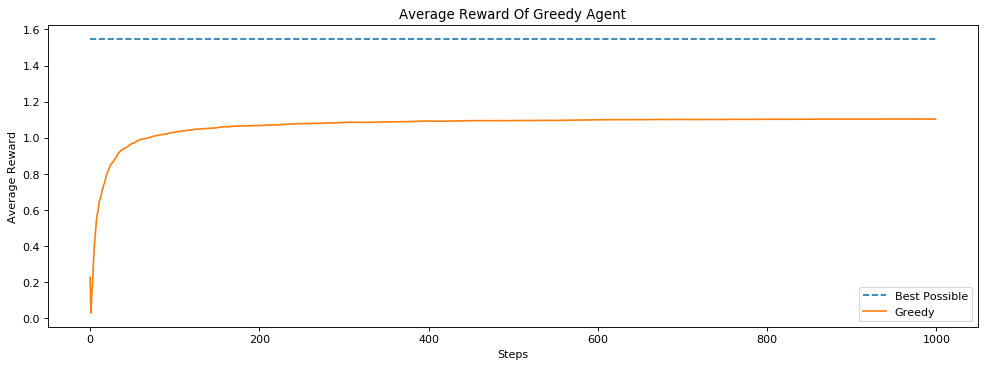

In [95]:
num_runs = 200
num_steps = 1000
env = ten_arm_env.Environment
agent = GreedyAgent
agent_info ={"num_actions":10} #available number of actions
env_info={} #environment information
all_averages =[]
for i in tqdm(range(num_runs)): #create progress bar
    rl_glue = RLGlue(env,agent)
    rl_glue.rl_init(agent_info,env_info)
    rl_glue.rl_start()
    scores=[0]
    averages=[]
    for i in range(num_steps):
        reward,_,action,_ = rl_glue.rl_step() #take a step and return reward
        scores.append(scores[-1]+reward)
        averages.append(scores[-1]/(i+1))
    all_averages.append(averages)

plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)],linestyle='--')
plt.plot(np.mean(all_averages,axis=0))
plt.legend(["Best Possible","Greedy"])
plt.title("Average Reward Of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()
greedy_scores = np.mean(all_averages,axis=0)
    


# Section 2: Epsilon-Greedy Agent

- It does not always take the greedy action. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action really is

In [99]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self,reward,observation):
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        # Randomly choose a number between 0 and 1 and see if it is less than self.epsilon
        # (Hint: look at np.random.random()). If it is, set current_action to a random action.
        # Otherwise choose current_action greedily as you did above.
        if(np.random.random()< self.epsilon):
#             print('hi')
            current_action = np.random.randint(0,len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        self.arm_count[self.last_action]+=1
        self.q_values[self.last_action]=self.q_values[self.last_action]+1/(self.arm_count[self.last_action])*(reward-self.q_values[self.last_action])
        self.last_action = current_action
        return current_action

In [100]:
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0,0,1,0,0]
e_greedy_agent.arm_count = [0,1,0,0,0]
e_greedy_agent.num_actions =5
e_greedy_agent.last_action =1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(1,0)
print(e_greedy_agent.q_values)

[0, 0.5, 1, 0, 0]


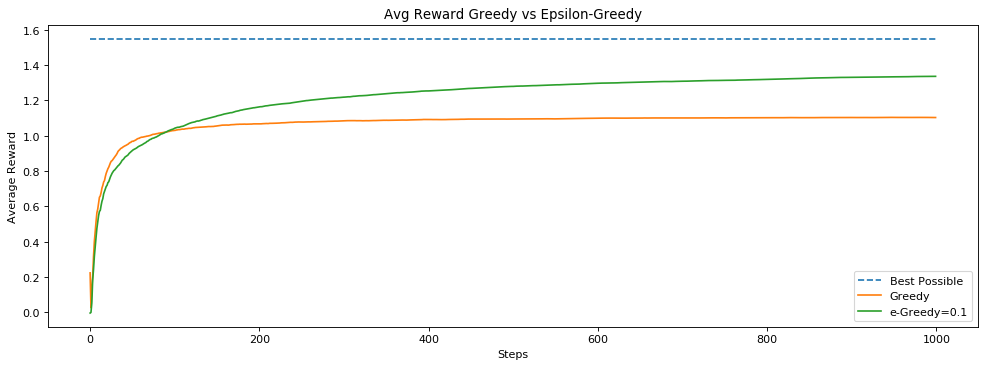

In [105]:
num_runs = 200
num_steps=1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env =ten_arm_env.Environment
agent_info={
    "num_actions":10,"epsilon":epsilon
}
env_info={}
all_averages=[]
for i in tqdm(range(num_runs)):
    rl_glue=RLGlue(env,agent)
    rl_glue.rl_init(agent_info,env_info)
    rl_glue.rl_start()
    scores=[0]
    averages=[]
    for i in range(num_steps):
        reward,_,action,_ = rl_glue.rl_step()
        scores.append(scores[-1]+reward)
        averages.append(scores[-1]/(i+1))
    all_averages.append(averages)
plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)],linestyle="--")
plt.plot(greedy_scores)
plt.plot(np.mean(all_averages,axis=0))
plt.title("Avg Reward Greedy vs Epsilon-Greedy")
plt.legend(("Best Possible","Greedy","e-Greedy=0.1"))
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()


# Averaging Multiple Runs

- To remove the noise we average the reward for all runs

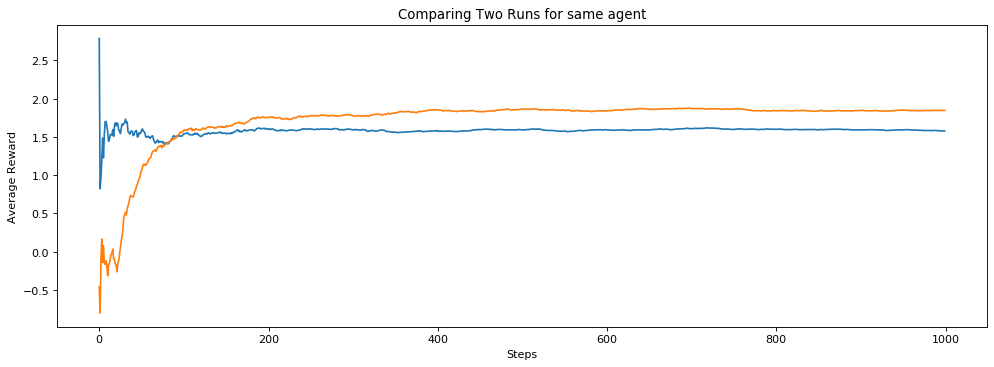

In [109]:
agent = EpsilonGreedyAgent
agent_info = {"num_actions":10,"epsilon": 0.1}
env_info ={}
all_averages = []
plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
num_steps = 1000

for run in (0,1):
    np.random.seed(run)
    averages=[]
    rl_glue = RLGlue(env,agent)
    rl_glue.rl_init(agent_info,env_info)
    rl_glue.rl_start()
    scores=[0]
    for i in range(num_steps):
        reward,state,action,is_terminal = rl_glue.rl_step()
        scores.append(scores[-1]+reward)
        averages.append(scores[-1]/(i+1))
    plt.plot(averages)
plt.title("Comparing Two Runs for same agent")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()
# The agent could get lucky, and see larger rewards for the best action early on and so settle on the best action faster. 
# Or, it could get unlucky and see smaller rewards for best action early on and 
# so take longer to recognize that it is in fact the best action.

## Section 3: Comparing Values Of Epsilon

C:\Users\vijaygarg01\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


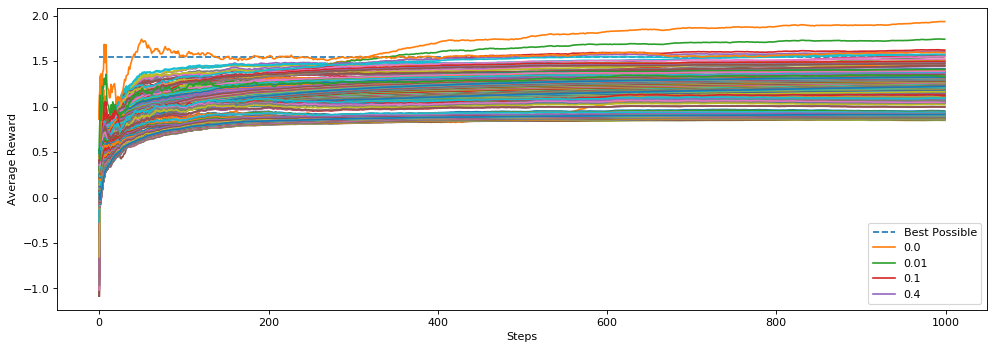

In [113]:
epsilons = [0.0,0.01,0.1,0.4]
plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)],linestyle="--")

n_q_values=[]
n_averages=[]
n_best_actions=[]
num_runs=200
for epsilon in epsilons:
    all_averages=[]
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info={"num_actions":10,"epsilon":epsilon}
        env_info={"random_seed":run}
        rl_glue = RLGlue(env,agent)
        rl_glue.rl_init(agent_info,env_info)
        rl_glue.rl_start()
        best_arm = np.argmax(rl_glue.environment.arms)
        scores=[0]
        averages=[]
        best_action_choosen=[]
        
        for i in range(num_steps):
            reward,state,action,is_terminal=rl_glue.rl_step()
            scores.append(scores[-1]+reward)
            averages.append(scores[-1]/(i+1))
            if(action==best_arm):
                best_action_choosen.append(1)
            else:
                best_action_choosen.append(0)
            if(epsilon==0.1 and run==0):
                n_q_values.append(np.copy(rl_glue.agent.q_values))
            if(epsilon==0.1):
                n_averages.append(averages)
                n_best_actions.append(best_action_choosen)
            all_averages.append(averages)
        plt.plot(np.mean(all_averages,axis=0))
plt.legend(["Best Possible"]+epsilons)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()
                
            


# Section 4:The Effect Of Step Size

The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1.

In [114]:
class EpsilonGreedyAgentConstantStepSize(main_agent.Agent):
    def agent_step(self,reward,observation):
        self.arm_count_count_count_count_count[self.last_q_valuesction]+=1
        self.q_step_sizees[self.last_aq_valuestion]+last_actionf.step_size*(reward-self.q_values[self.last_action])
        if(np.random.random()<self.epsilon):
            current_action = np.random.randint(len(self.q_values))
        else:
            culast_actiont_action = argmax(self.q_values)
        self.last_action = current_action
        return current_action

In [115]:
for stepsize in [0.01,0.1,0.5,1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantSize()
    e_greedy_agent.q_values = [0,0,1,0,0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action=1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1,0)
    print(stepsizep_size)
    print(e_greedy_agent.q_values)
    

NameError: name 'EpsilonGreedyAgentConstantSize' is not defined

In [ ]:
step_sizes = [0.01,0.1,0.5,1.0]
epsilon = 0.1
num_steps = 1000
num_runs = 200

fig , ax = plt.subplots(figsize=(15,5),dpi=80,facecolor = 'w',edgecolor='k')
q_values ={step_size:[] for step_size in step_sizes}
true_values = {step_size:None for step_size in step_sizes }
best_actions = {step_size:[] for step_size in step_sizes}
for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = {"num_actions":10,"epsilon":epsilon,"step_size":step_size,"initial_value":0.0}
        env_info = {"random_seed":run}
        rl_glue = RLGlue(env,agent)
        rl_glue.rl_init(agent_info,env_info)
        rl_glue.rl_start()
        best_arm = np.argmax(rl_glue.environment.arms)
        scores=[0]
        averages=[]
        if(run==0):
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            best_action_chosen=[]
        for i in range(num_steps):
            reward,state,action,is_terminal = rl_glue.rl_step()
            scores.append(scores[-1]+reward)
            averages.append(scores[-1]/(i+1))
            if(action==best_arm):
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if(run==0):
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size],axis=0))
    if(step_size==0.01):
        np.save("step-size",best_actions[step_size])
ax.plot(np.mean(n_best_actions,axis=0)
fig.legend(step_sizes+["1/N(A)"])
plt.title("% Best Action Taken")
plt.xlabel("Steps")
plt.ylabel("%Best Action ")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

In [ ]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)],linestyle="--")
    plt.title("step size: { }".format(step_size))
    plt.plot(np.array(q_values[step_size])[:,largest])
    plt.legend("True Expected Value","Estimated Value")
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()
plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
plt.title("Step Size: 1/N(A)")
plt.plot([true_values[step_size][largest] for _ in range(num_steps)],linestype="--")
plt.plot(np.array(n_q_values)[:,largest])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.legend(["True Expected Value","Estimated Value"])
plt.show()


step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is. A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.it might not be as effective is in non-stationary problems

In [ ]:
epsilon=0.1
num_steps=2000
num_runs=200
step_size=0.1
plt.figure(figsize=(15,5),dpi=80,facecolor='w',edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)],linestyle="--")
for agent in [EpsilonGreedyAgent,EpsilonGreedyAgentConstantStepsize]:
    all_averages=[]
    for run in tqdm(range(num_runs)):
        agent_info={"num_actions":10,"epsilon":epsilon,"step_size":step_size}
        env_info= {"random_seed":run}
        rl_glue = RLGlue(env,agent)
        rl_glue.rl_init(agent_info,env_info)
        rl_glue.rl_start()
        scores = [0]
        averages = []
        for i in range(num_steps):
            reward , state,action,is_terminal = rl_glue.rl_step()
            scores.append(scores[-1]+reward)
            averages.append(scores[-1]/(i+1))
            if(i==1000):
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
    plt.plot(np.mean(all_averages,axis=0))
plt.legend(["Best Possible", "1/N(A)","0.1"])
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error.

The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.

These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment.